# **Исследование данных музыкального сервиса - сравнение музыкальных предпочтений пользователей двух городов**
---

**Цель исследования** — проверка трёх гипотез:
1. Активность пользователей зависит от дня недели. Причём в в разных городах это проявляется по-разному.
2. В понедельник в одном городе преобладают одни жанры, а в другом — другие. Так же и в пятницу преобладают разные жанры — в зависимости от города.
3. В разных городах предпочитают разные жанры музыки.

**Ход исследования**

Данные о поведении пользователей хранятся взяты с kaggle. О качестве данных ничего не известно. Поэтому перед проверкой гипотез понадобится обзор данных. 

Необходимо проверить данные на ошибки и оценить их влияние на исследование. Затем, на этапе предобработки следует поискать возможность исправить самые критичные ошибки данных.
 
Таким образом, исследование пройдёт в три этапа:
 1. Обзор данных.
 2. Предобработка данных.
 3. Проверка гипотез.

---

## Обзор данных

Составим первое представление о данных.

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

Прочитаем файлы, соедим, отберём нужные столбцы и сохраним его в файл `df_songs.csv`:

In [28]:
#song_df = pd.read_csv('songs.csv')
#song_ex_df = pd.read_csv('song_extra_info.csv')
#user_df = pd.read_csv('members.csv')
#train_df = pd.read_csv('train.csv')
#s_se = pd.merge(train_df, song_df, on='song_id', how='left')
#s_se_t = pd.merge(s_se, song_ex_df, on='song_id', how='left')
#songs = pd.merge(s_se_t, user_df, on='msno', how='left')
#songs = songs.iloc[:, [0, 12, 8, 7, 14, 6, 18]] # Оставляем только нужные столбцы
#del song_df, song_ex_df, user_df, train_df, s_se, s_se_t

Для анализа возьмем 8й и 9й город.

In [29]:
#songs.city.value_counts()
#songs = songs.loc[(songs.city == 8) | (songs.city == 9)]
#songs = songs.reset_index(drop=True)
#songs.to_csv('df_songs.csv',)

In [30]:
songs = pd.read_csv('df_songs.csv', index_col=0)

In [31]:
songs.head()

,msno,name,artist_name,genre_ids,city,song_length,registration_init_time
0,uQQHTQJ1nVEkBfbXe0f1/J9ML5eQhsQiocCV5TvvCRI=,雨天 (雨天),孫燕姿 (Yanzi Sun),465,9,241975.0,20130912
1,uQQHTQJ1nVEkBfbXe0f1/J9ML5eQhsQiocCV5TvvCRI=,EGO-HOLIC戀我癖 (EGO-HOLIC),陳星翰 (Starr Chen),458,9,189846.0,20130912
2,uQQHTQJ1nVEkBfbXe0f1/J9ML5eQhsQiocCV5TvvCRI=,愛死你,莫文蔚 (Karen Mok),465,9,247911.0,20130912
3,uQQHTQJ1nVEkBfbXe0f1/J9ML5eQhsQiocCV5TvvCRI=,麥來亂,五月天 (Mayday),465,9,257671.0,20130912
4,Ix1RlLsCGktMc8Q5oogErdJbfKL+HYj116+bYZ4qzMc=,愛久見人心,梁靜茹 (Fish Leong),458,8,296542.0,20130722


In [32]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180971 entries, 0 to 180970
Data columns (total 7 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   msno                    180971 non-null  object 
 1   name                    180936 non-null  object 
 2   artist_name             180969 non-null  object 
 3   genre_ids               178048 non-null  object 
 4   city                    180971 non-null  int64  
 5   song_length             180969 non-null  float64
 6   registration_init_time  180971 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 11.0+ MB


Итак, в таблице у нас получилось семь столбцов.

Согласно документации к данным:
* `msno` — идентификатор пользователя;
* `name` — название трека;  
* `artist_name` — имя исполнителя;
* `genre_ids` — id жанра;
* `city` — город пользователя;
* `song_length` — длительность песни;
* `registration_init_time` — дата первого прослушивания;


Количество значений в столбцах различается. Значит, в данных есть пропущенные значения.

#### **Выводы**

В каждой строке таблицы — данные о прослушанном треке. Часть колонок описывает саму композицию: название, исполнителя и жанр. Остальные данные рассказывают о пользователе: из какого он города, когда он слушал музыку.

Предварительно можно утверждать, что, данных достаточно для проверки гипотез. Но встречаются пропуски в данных.

Пропуски в данных наблюдаются только в колонках, описывающих саму композицию, что может свидетельствовать об ошибках при извлечении данных о композициях, либо о том, что в системе поля Track, artist и genre_ids являются необязательными и теоретически возможна ситуация, когда все три поля будут пропущены одновременно. Целесообразно проконсультироваться с разработчиками.

С точки зрения постановки задачи наиболее важным является столбец genre_ids.

Чтобы двигаться дальше, устраним проблемы в данных.

## **Предобработка данных**
Исправим стиль в заголовках столбцов, исключим пропуски.

### Стиль заголовков
Выведем на экран названия столбцов:

In [33]:
songs.columns

Index(['msno', 'name', 'artist_name', 'genre_ids', 'city', 'song_length',
       'registration_init_time'],
      dtype='object')

In [34]:
# Изменим названия на более понятные.
songs = songs.rename(
    columns={
        'msno' : 'user_id',
        'name' : 'track',
        'artist_name' : 'artist',
        'genre_ids' : 'genre_id',
        'registration_init_time' : 'date'
    }
)

In [35]:
# проверка результатов - перечень названий столбцов
songs.columns

Index(['user_id', 'track', 'artist', 'genre_id', 'city', 'song_length',
       'date'],
      dtype='object')

### Работа с пропущенными значениями
Сначала посчитаем, сколько в таблице пропущенных значений:

In [36]:
# подсчёт пропусков
songs.isna().sum()

user_id           0
track            35
artist            2
genre_id       2923
city              0
song_length       2
date              0
dtype: int64

In [37]:
columns_to_replace = ['track', 'artist', 'genre_id', 'song_length']

for col in columns_to_replace:
    songs[col] = songs[col].fillna('unknown')

### Дубликаты
Посчитаем явные дубликаты в таблице:

In [38]:
songs.duplicated().sum()

626

Удалим явные дубликаты:

In [39]:
# удаление явных дубликатов
songs = songs.drop_duplicates()

Ещё раз посчитаем явные дубликаты, чтобы убедиться, что полностью от них избавились:

In [40]:
# проверка на отсутствие дубликатов
songs.duplicated().sum()

0

Теперь избавимся от неявных дубликатов в колонке `genre_ids`. Например, в данных id могут быть записаны парами. Такие ошибки тоже повлияют на результат исследования.

Выведем на экран список уникальных названий жанров, отсортированный в алфавитном порядке. Для этого:
* извлеките нужный столбец датафрейма
* примените к нему метод сортировки
* для отсортированного столбца вызовите метод, который вернёт уникальные значения из столбца

In [41]:
# Просмотр уникальных названий жанров
songs['genre_id'].sort_values().unique()

array(['1011', '1026', '1040', '1040|1155', '1047', '1054', '1082', '109',
       '1096', '109|118', '109|139', '109|465', '109|94', '1117', '1138',
       '1145', '1152', '1152|2022', '1152|242|947', '1152|465',
       '1152|465|1180', '1152|726', '1152|786', '1152|829', '1152|921',
       '1152|940', '1152|947', '1155', '118', '1180', '1180|2022',
       '1180|465', '118|1259', '1208', '1259', '1259|359', '1266', '1273',
       '1280', '1280|2093', '1287', '139', '139|1259', '139|1259|125|109',
       '139|125|109', '139|444|109', '1568', '1572|275', '1598', '1605',
       '1609', '1609|1259', '1609|139', '1609|1969|2100', '1609|2058',
       '1609|2086|374', '1609|2107', '1609|2122', '1609|2122|2022',
       '1609|359', '1609|458', '1609|465', '1609|786', '1609|947|2022',
       '1616', '1616|1609', '1616|2058', '1616|2072', '1616|2116', '1633',
       '1633|310', '1944|310', '1955', '1969', '1969|1609|2100',
       '1988|1981|430', '2022', '2022|1259', '2022|1955', '2022|359',
    

В списке выявлены следующие неявные дубликаты:
Парные id

Чтобы очистить от них таблицу, напишем функцию `replace_wrong_genres()` с одним параметром: 
* `gen` — список id

Функция исправляет колонку `genre_id` в таблице `songs`: заменяет каждое значение c символом `|` на первый id.

In [42]:
# функция для замены неявных дубликатов
def replace_wrong_genres(gen):
    nw_gen = []
    for i in gen:
        index = i.find('|')
        if index != -1:
            i = i[:index]
        nw_gen.append(i)
    return nw_gen

Устраним неявные дубликаты

In [43]:
songs['genre_id'] = replace_wrong_genres(songs['genre_id'])

Проверим корректность устранения неявных дубликатов. Выведем отсортированный список уникальных значений столбца `genre`:

In [44]:
# Проверка на неявные дубликаты
songs['genre_id'].sort_values().unique()

array(['1011', '1026', '1040', '1047', '1054', '1082', '109', '1096',
       '1117', '1138', '1145', '1152', '1155', '118', '1180', '1208',
       '1259', '1266', '1273', '1280', '1287', '139', '1568', '1572',
       '1598', '1605', '1609', '1616', '1633', '1944', '1955', '1969',
       '1988', '2022', '2029', '2032', '2072', '2079', '2086', '2093',
       '2107', '2109', '2116', '212', '2122', '2130', '2144', '2157',
       '2176', '2189', '2194', '2213', '2248', '242', '252', '275', '352',
       '359', '374', '381', '388', '402', '409', '423', '430', '437',
       '444', '451', '458', '465', '474', '481', '509', '516', '531',
       '545', '656', '691', '698', '712', '719', '726', '786', '798',
       '822', '829', '864', '873', '880', '893', '900', '921', '94',
       '940', '947', '95', '958', '965', '972', '979', '986', 'unknown'],
      dtype=object)

### Заменим данные в столбце `date` с полной даты на день недели.

Напишим функцию, которая будет получать дату в формате ГГГГММДД и выдавать день недели. Для этого используем модуль datetime.

In [45]:
# Создадим словарь
week_day = {0: 'Понедельник', 1: 'Вторник', 2: 'Среда', 3: 'Четверг', 4: 'Пятница', 5: 'Суббота', 6: 'Воскресенье'}

def to_week_day(lst_date):
    lst_week_day = []
    for sdate in lst_date:
        week_id = datetime.datetime(sdate//10000, sdate%10000//100, sdate%100)
        lst_week_day.append(week_day[week_id.weekday()])  
    return lst_week_day

In [46]:
songs['name'] = to_week_day(songs['date'])
songs['date']

0             Четверг
1             Четверг
2             Четверг
3             Четверг
4         Понедельник
             ...     
180966    Воскресенье
180967    Воскресенье
180968    Воскресенье
180969    Воскресенье
180970    Воскресенье
Name: date, Length: 180345, dtype: object

**Выводы**

Предобработка обнаружила три проблемы в данных:

- нарушения в стиле заголовков,
- пропущенные значения,
- дубликаты — явные и неявные.

Мы исправили заголовки, чтобы упростить работу с таблицей. Без дубликатов исследование станет более точным.

Пропущенные значения мы заменили на `'unknown'`. Ещё предстоит увидеть, не повредят ли исследованию пропуски в колонке `genre_id`.

Теперь можно перейти к проверке гипотез. 

---

## Проверка гипотез

**1.** Активность пользователей зависит от дня недели. Причём в в разных городах это проявляется по-разному.

Сравним распределение активности по по дням недели.

In [83]:
event_week = songs.groupby('date')['city'].count().sort_values()
event_week

date
Среда          20412
Вторник        21011
Понедельник    24111
Четверг        26743
Суббота        27503
Пятница        28490
Воскресенье    32075
Name: city, dtype: int64

Text(0.5, 1.0, 'Количество прослушиваний по дням недели')

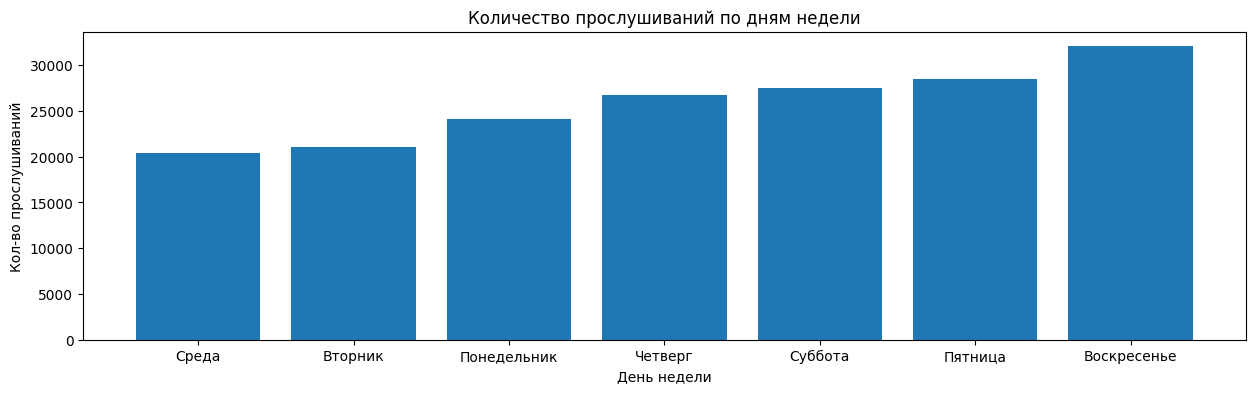

In [84]:
plt.figure(figsize=(15,4))
plt.bar(range(len(event_week)), event_week)
plt.xlabel('День недели')
plt.xticks(range(len(event_week)), event_week.index)
plt.ylabel('Кол-во прослушиваний')
plt.title('Количество прослушиваний по дням недели')

Теперь посмотрим это распределение для каждого города.

Город №8:

In [85]:
event_week_8 = songs[songs['city']==8].groupby('date')['city'].count().sort_values()
event_week_8

date
Среда           6383
Вторник         9364
Суббота        10420
Понедельник    11809
Четверг        13148
Пятница        14703
Воскресенье    19614
Name: city, dtype: int64

Text(0.5, 1.0, 'Количество прослушиваний по дням недели')

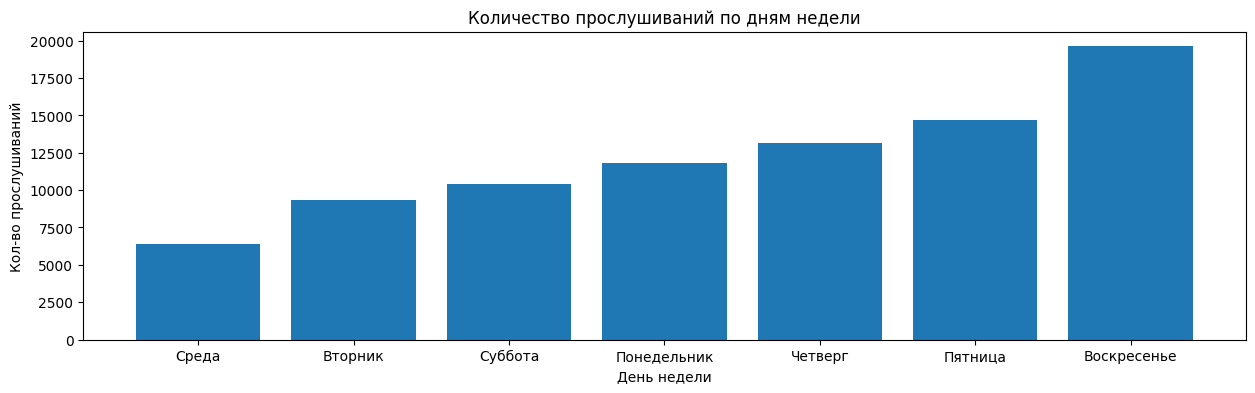

In [86]:
plt.figure(figsize=(15,4))
plt.bar(range(len(event_week)), event_week_8)
plt.xlabel('День недели')
plt.xticks(range(len(event_week)), event_week_8.index)
plt.ylabel('Кол-во прослушиваний')
plt.title('Количество прослушиваний по дням недели')

Город №9:

In [81]:
event_week_9 = songs[songs['city']==9].groupby('date')['city'].count().sort_values()
event_week_9

date
Вторник        11647
Понедельник    12302
Воскресенье    12461
Четверг        13595
Пятница        13787
Среда          14029
Суббота        17083
Name: city, dtype: int64

Text(0.5, 1.0, 'Количество прослушиваний по дням недели')

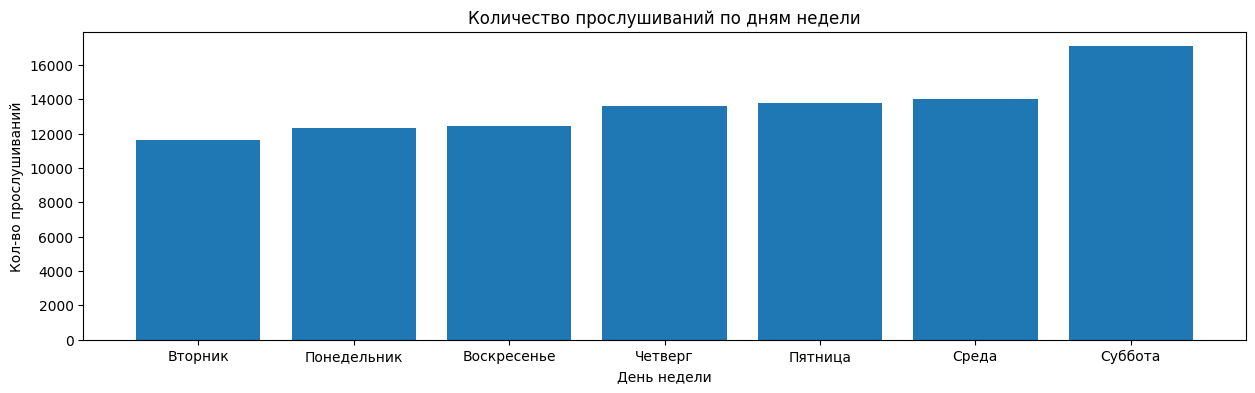

In [82]:
plt.figure(figsize=(15,4))
plt.bar(range(len(event_week)), event_week_9)
plt.xlabel('День недели')
plt.xticks(range(len(event_week)), event_week_9.index)
plt.ylabel('Кол-во прослушиваний')
plt.title('Количество прослушиваний по дням недели')

In [88]:
event_week_9.describe()

count        7.000000
mean     13557.714286
std       1785.783742
min      11647.000000
25%      12381.500000
50%      13595.000000
75%      13908.000000
max      17083.000000
Name: city, dtype: float64